In [1]:
%load_ext watermark
%watermark -a 'Sebastian Raschka' -v -p torch

Author: Sebastian Raschka

Python implementation: CPython
Python version       : 3.8.8
IPython version      : 8.2.0

torch: 1.11.0



# Baseline -- Convolutional Neural Network on MNIST

## Imports

In [2]:
import os
import time

import numpy as np
import torch
import torch.nn.functional as F

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

## Settings

In [3]:
##########################
### SETTINGS
##########################

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Hyperparameters
random_seed = 1
learning_rate = 0.001
num_epochs = 10
batch_size = 128

# Architecture
num_classes = 10

## Dataset

In [4]:
#!pip install gitpython

In [5]:
import os

from git import Repo

if not os.path.exists("mnist-pngs"):
    Repo.clone_from("https://github.com/rasbt/mnist-pngs", "mnist-pngs")

In [6]:
from torchvision import transforms

data_transforms = {
    "train": transforms.Compose(
        [
            transforms.Resize(32),
            transforms.RandomCrop((28, 28)),
            transforms.ToTensor(),
            # normalize images to [-1, 1] range
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    ),
    "test": transforms.Compose(
        [
            transforms.Resize(32),
            transforms.CenterCrop((28, 28)),
            transforms.ToTensor(),
            # normalize images to [-1, 1] range
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    ),
}

In [7]:
from torch.utils.data.dataset import random_split
from torchvision.datasets import ImageFolder

train_dset = ImageFolder(root="mnist-pngs/train", transform=data_transforms["train"])

train_dset, valid_dset = random_split(train_dset, lengths=[55000, 5000])

test_dset = ImageFolder(root="mnist-pngs/test", transform=data_transforms["test"])

In [8]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
    dataset=train_dset,
    batch_size=batch_size,
    drop_last=True,
    num_workers=4,
    shuffle=True,
)

valid_loader = DataLoader(
    dataset=valid_dset,
    batch_size=batch_size,
    drop_last=False,
    num_workers=4,
    shuffle=False,
)

test_loader = DataLoader(
    dataset=test_dset,
    batch_size=batch_size,
    drop_last=False,
    num_workers=4,
    shuffle=False,
)

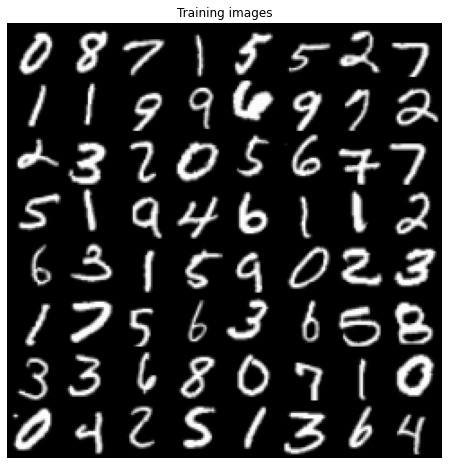

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import torchvision.utils as vutils

real_batch = next(iter(train_loader))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training images")
plt.imshow(
    np.transpose(
        vutils.make_grid(real_batch[0][:64], padding=2, normalize=True), (1, 2, 0)
    )
)
plt.show()

## Model

In [10]:
import torch


class PyTorchCNN(torch.nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.num_classes = num_classes
        self.features = torch.nn.Sequential(
            torch.nn.Conv2d(
                in_channels=3,
                out_channels=8,
                kernel_size=(3, 3),
                stride=(1, 1),
                padding=1,
            ),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0),
            torch.nn.ReLU(),
            torch.nn.Conv2d(
                in_channels=8,
                out_channels=16,
                kernel_size=(3, 3),
                stride=(1, 1),
                padding=1,
            ),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0),
        )

        self.classifier = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(784, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


torch.manual_seed(random_seed)
model = PyTorchCNN(num_classes=num_classes)
model = model.to(device)

## Training

In [11]:
def compute_accuracy(model, data_loader, device):
    with torch.no_grad():
        correct_pred, num_examples = 0, 0
        for features, targets in data_loader:
            features, targets = features.to(device), targets.to(device)
            logits = model(features)
            _, predicted_labels = torch.max(logits, 1)
            num_examples += targets.size(0)
            correct_pred += (predicted_labels == targets).sum()
        return correct_pred.float() / num_examples

In [12]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

start_time = time.time()
for epoch in range(num_epochs):
    model = model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):

        features, targets = features.to(device), targets.to(device)

        ### Forward pass
        logits = model(features)
        loss = F.cross_entropy(logits, targets)

        ### Backward pass (backpropagation)
        optimizer.zero_grad()
        loss.backward()

        ### Update model parameters
        optimizer.step()

        ### Batch-level logging
        if not (batch_idx + 1) % 100:
            print(
                f"Epoch: {epoch + 1:03d}/{num_epochs:03d} | "
                f"Batch: {batch_idx + 1:03d}/{len(train_loader):03d} | "
                f"Loss: {loss:.4f}"
            )

    ### Epoch-level logging
    model = model.eval()
    train_acc = compute_accuracy(model, train_loader, device)
    valid_acc = compute_accuracy(model, valid_loader, device)
    print(
        f"Training accuracy: {train_acc * 100:.2f}% | "
        f"Validation accuracy: {valid_acc * 100:.2f}%"
    )
    print(f"Time elapsed: {(time.time() - start_time) / 60:.2f} min")

print(f"Total training time: {(time.time() - start_time) / 60:.2f} min")

Epoch: 001/010 | Batch: 100/429 | Loss: 0.5552
Epoch: 001/010 | Batch: 200/429 | Loss: 0.2319
Epoch: 001/010 | Batch: 300/429 | Loss: 0.2143
Epoch: 001/010 | Batch: 400/429 | Loss: 0.0994
Training accuracy: 94.31% | Validation accuracy: 94.54%
Time elapsed: 0.35 min
Epoch: 002/010 | Batch: 100/429 | Loss: 0.1547
Epoch: 002/010 | Batch: 200/429 | Loss: 0.1337
Epoch: 002/010 | Batch: 300/429 | Loss: 0.1000
Epoch: 002/010 | Batch: 400/429 | Loss: 0.0994
Training accuracy: 97.23% | Validation accuracy: 97.30%
Time elapsed: 0.71 min
Epoch: 003/010 | Batch: 100/429 | Loss: 0.0571
Epoch: 003/010 | Batch: 200/429 | Loss: 0.0435
Epoch: 003/010 | Batch: 300/429 | Loss: 0.0878
Epoch: 003/010 | Batch: 400/429 | Loss: 0.0801
Training accuracy: 97.49% | Validation accuracy: 97.58%
Time elapsed: 1.06 min
Epoch: 004/010 | Batch: 100/429 | Loss: 0.0970
Epoch: 004/010 | Batch: 200/429 | Loss: 0.0683
Epoch: 004/010 | Batch: 300/429 | Loss: 0.1192
Epoch: 004/010 | Batch: 400/429 | Loss: 0.0644
Training ac

## Evaluation

In [13]:
test_acc = compute_accuracy(model, test_loader, device)
print(f"Test accuracy: {test_acc*100:.2f}%")

Test accuracy: 99.14%


In [14]:
%watermark -iv

numpy      : 1.19.5
torch      : 1.11.0
matplotlib : 3.3.4
torchvision: 0.12.0

